# Filtering tiles
We can reduce the compute time and prevent many false-positive errors by restricting the analysis to the tiles that are likely to contain sea ice. 

This notebook produces the tilewise image measures used to train the algorithm. Training for now is done in a Python notebook; future work can implement GLM.jl to train the dataset automatically.

In [13]:
using Pkg
Pkg.activate("calval")
using IceFloeTracker
using Images
using CSV
using Plots
include("../scripts/dev/validation_data.jl")
include("../scripts/dev/filter_tiles.jl")

  Activating project at `~/Documents/research/calval_tgrs/notebooks/calval`


filter_function (generic function with 1 method)

In [146]:
cloud_mask_settings = (
    prelim_threshold=53.0/255.,
    band_7_threshold=130.0/255.,
    band_2_threshold=169.0/255.,
    ratio_lower=0.0,
    ratio_offset=0.0,
    ratio_upper=0.53
)

cmask = LopezAcostaCloudMask(cloud_mask_settings...)
dataloc = "../data/validation_dataset/modis_500km"
tc_filenames = filter(x -> !occursin(".DS", x), readdir(joinpath(dataloc, "truecolor")))


data_loader = Watkins2025GitHub(; ref="a451cd5e62a10309a9640fbbe6b32a236fcebc70")
dataset = data_loader(c -> c.case_number == 29 && c.satellite == "terra");

┌ Warning: In /tmp/Watkins2025/a451cd5e62a10309a9640fbbe6b32a236fcebc70/validation_dataset.csv line 381 has 0 fields but 28 fields are expected. Skipping row.
└ @ TextParse ~/.julia/packages/TextParse/bX5Ws/src/csv.jl:390


In [147]:
case = first(dataset)
landmask = Gray.(case.modis_landmask) .> 0
land_mask = IceFloeTracker.create_landmask(landmask, strel_diamond((11,11)))
tc_img = RGB.(case.modis_truecolor)
fc_img = RGB.(case.modis_falsecolor)
nothing

In [148]:
cloud_mask = IceFloeTracker.create_cloudmask(fc_img, cmask);

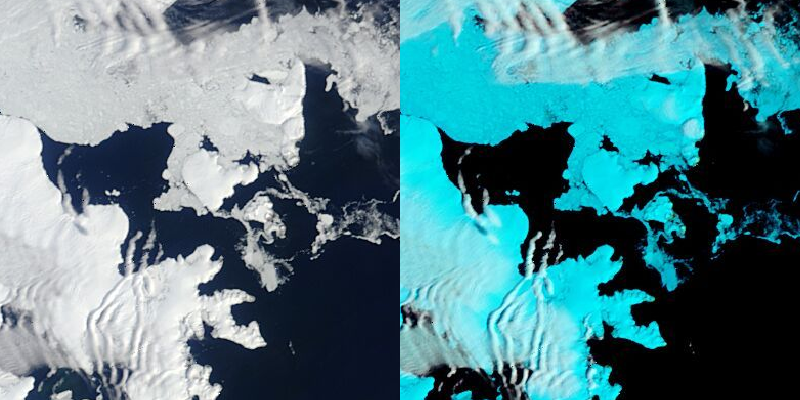

In [153]:

mosaicview(tc_img, fc_img, nrow=1)

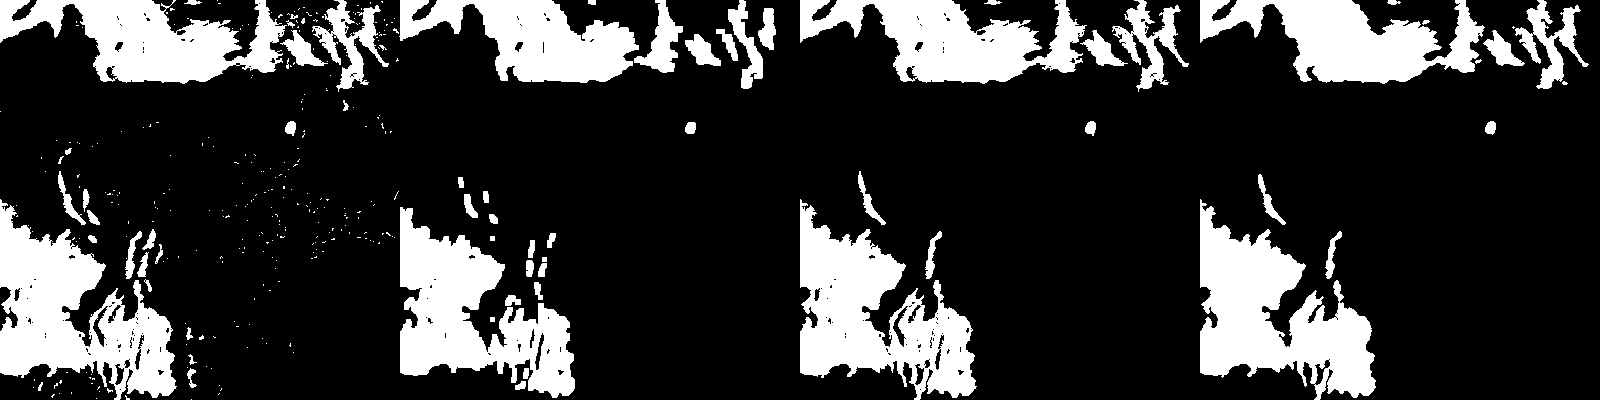

In [149]:
markers = opening(cloud_mask, strel_box((7,7)))
reconstructed = mreconstruct(dilate, markers, cloud_mask, strel_diamond((3,3)))
smoothed = opening(reconstructed, strel_diamond((3,3)))
cm_filled = IceFloeTracker.fill_holes(smoothed)
mosaicview(Gray.(cloud_mask), Gray.(opening(cloud_mask, se)), reconstructed, cm_filled, nrow=1)

In [150]:
n = size(tc_img) .÷ 2
tiles = IceFloeTracker.get_tiles(tc_img, n)
tile_markers = zeros(size(cloud_mask))
lm = .!land_mask.dilated
for tile in filter(t -> filter_function(tc_img[t...], fc_img[t...], cm_filled[t...], lm[t...]), tiles)
    tile_markers[tile...] .= 1
end

tc_landmasked = IceFloeTracker.apply_landmask(tc_img, .!lm)
tc_cloudmasked = IceFloeTracker.apply_cloudmask(tc_landmasked, cm_filled)
tc_masked = tc_landmasked .* tile_markers;

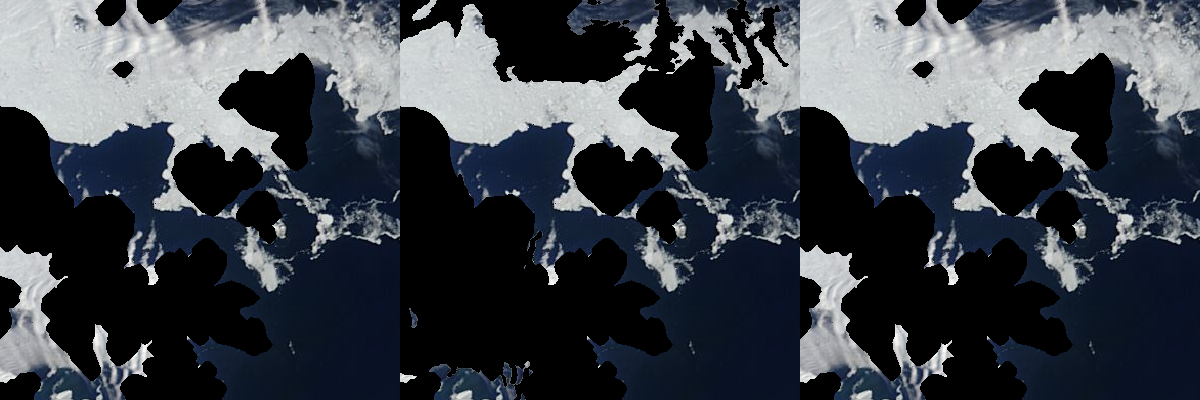

In [151]:
img = mosaicview(tc_landmasked, tc_cloudmasked, tc_masked, nrow=1)

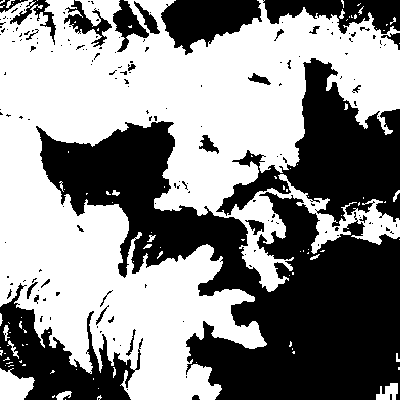

In [152]:
Gray.(binarize(tc_img, AdaptiveThreshold(window_size=200, percentage=0)))

# Example with 500 km image

In [157]:
tc_filename = "086-east_siberian_sea-500km-20060927-aqua-250m-truecolor.tiff"
fc_filename = replace(tc_filename, "truecolor" => "falsecolor")
markers_filename = replace(replace(tc_filename, "truecolor" => "markers"), "tiff" => "png")
landmask_filename = occursin("aqua", tc_filename) ? replace(tc_filename, "aqua-" => "") : replace(tc_filename, "terra-" => "")
landmask_filename = replace(landmask_filename, "truecolor" => "landmask")

landmask_filename = occursin("aqua", tc_filename) ? replace(tc_filename, "aqua-" => "") : replace(tc_filename, "terra-" => "")
landmask_filename = replace(landmask_filename, "truecolor" => "landmask")

tc_image = RGB.(load(joinpath(dataloc, "truecolor", tc_filename)))
fc_image = RGB.(load(joinpath(dataloc, "falsecolor", replace(tc_filename, "truecolor" => "falsecolor"))))
true_markers = Gray.(load(joinpath(dataloc, "tile_markers", markers_filename))) .> 0

n = 98
tiles = IceFloeTracker.get_tiles(tc_image, n)
    
# use the markers to make a checkerboard
for tile in filter(t -> maximum(true_markers[t...]) .> 0, tiles)
    true_markers[tile...] .= 1
end
land_image = Gray.(load(joinpath(dataloc, "landmask", landmask_filename)));
cloud_mask = IceFloeTracker.create_cloudmask(fc_image, cmask)
land_mask = land_image .> 0.1; # Replace with landmask, use dilated land mask in computation

In [158]:
tile_markers = zeros(size(cloud_mask))
for tile in filter(t -> filter_function(tc_image[t...], fc_image[t...], cloud_mask[t...], land_mask[t...]), tiles)
    tile_markers[tile...] .= 1
end

tc_masked = IceFloeTracker.apply_landmask(tc_image, .!land_mask)
tc_masked = tc_masked .* tile_markers;

Top: manual masks  
Bottom: Automatic masks

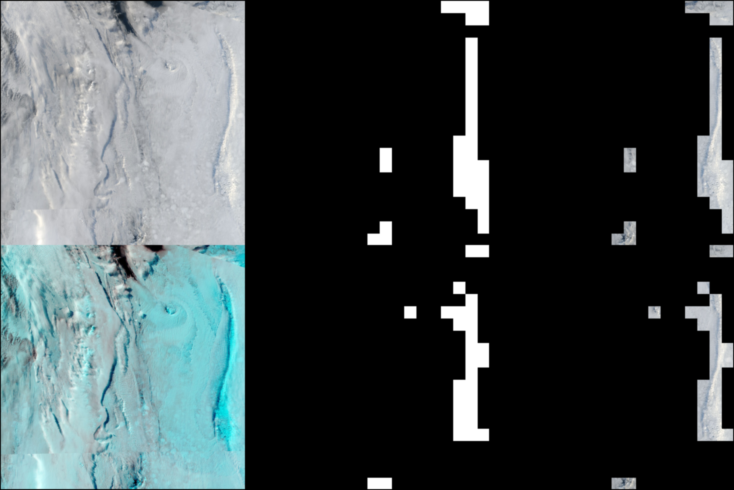

In [159]:
mosaicview(tc_image, fc_image, Gray.(true_markers), Gray.(tile_markers), tc_image .* true_markers, tc_image .* tile_markers, nrow=2)

# Example with the large default image (Beaufort-Chukchi Seas)

In [169]:
tc_img = load("../../IceFloeTracker.jl/test/test_inputs/beaufort-chukchi-seas_truecolor.2020162.aqua.250m.tiff")
fc_img = load("../../IceFloeTracker.jl/test/test_inputs/beaufort-chukchi-seas_falsecolor.2020162.aqua.250m.tiff")
cloud_mask = IceFloeTracker.create_cloudmask(fc_img, cmask)
land_mask = IceFloeTracker.create_landmask(load("../../IceFloeTracker.jl/test/test_inputs/landmask.tiff"), strel_diamond((11,11)))
cloud_mask = cloud_mask .* land_mask.non_dilated;

In [174]:
tiles = IceFloeTracker.get_tiles(tc_img, 400)
tile_markers = zeros(size(cloud_mask))
for tile in filter(t -> filter_function(tc_img[t...], fc_img[t...], cloud_mask[t...], .!land_mask.dilated[t...]), tiles)
    tile_markers[tile...] .= 1
end

tc_masked = tc_img .* land_mask.non_dilated
tc_masked = tc_masked .* tile_markers;

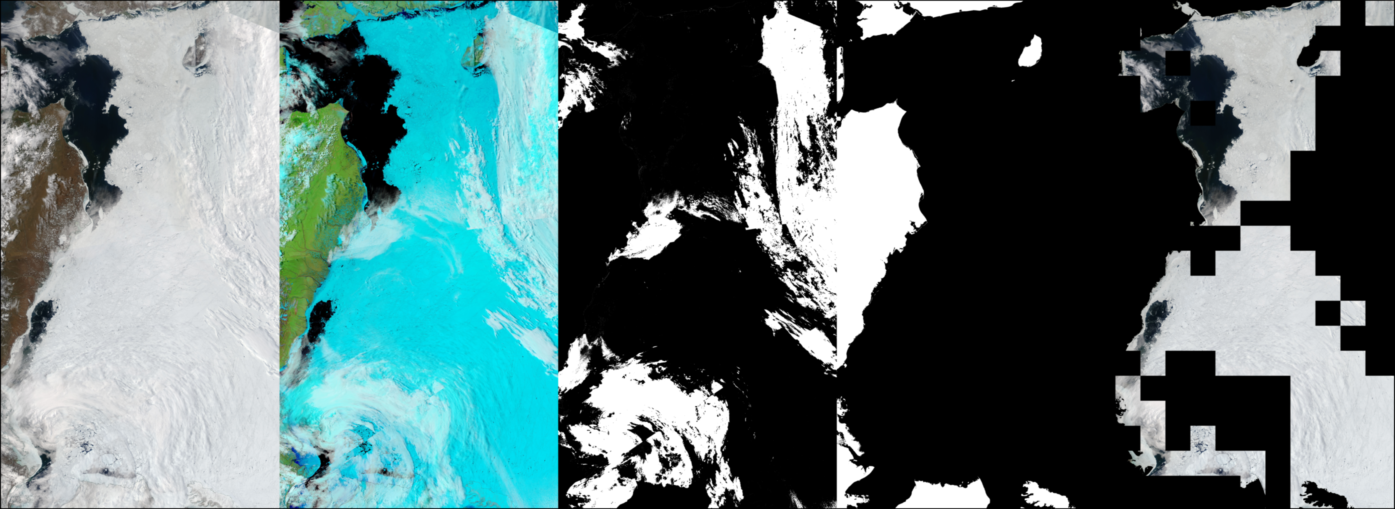

In [175]:
mosaicview(tc_img, fc_img, Gray.(cloud_mask), Gray.(.!land_mask.non_dilated), tc_masked, nrow=1)